In [12]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries

In [3]:
# Load time series of multiple lengths and exogenous variables
# ==============================================================================
series = pd.read_csv(
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast-datasets/main/data/demo_multi_series.csv'
)
exog = pd.read_csv(
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast-datasets/main/data/demo_multi_series_exog.csv'
)

series['timestamp'] = pd.to_datetime(series['timestamp'])
exog['timestamp'] = pd.to_datetime(exog['timestamp'])

display(series.head())
print("")
display(exog.head())

,series_id,timestamp,value
0,id_1000,2016-01-01,1012.500694
1,id_1000,2016-01-02,1158.500099
2,id_1000,2016-01-03,983.000099
3,id_1000,2016-01-04,1675.750496
4,id_1000,2016-01-05,1586.250694


,series_id,timestamp,sin_day_of_week,cos_day_of_week,air_temperature,wind_speed
0,id_1000,2016-01-01,-0.433884,-0.900969,6.416639,4.040115
1,id_1000,2016-01-02,-0.974928,-0.222521,6.366474,4.530395
2,id_1000,2016-01-03,-0.781831,0.623490,6.555272,3.273064
3,id_1000,2016-01-04,0.000000,1.000000,6.704778,4.865404
4,id_1000,2016-01-05,0.781831,0.623490,2.392998,5.228913


In [4]:
# Transform series and exog to dictionaries
# ==============================================================================
series_dict = series_long_to_dict(
    data      = series,
    series_id = 'series_id',
    index     = 'timestamp',
    values    = 'value',
    freq      = 'D'
)

exog_dict = exog_long_to_dict(
    data      = exog,
    series_id = 'series_id',
    index     = 'timestamp',
    freq      = 'D'
)

In [5]:
# Partition data in train and test
# ==============================================================================
end_train = '2016-07-31 23:59:00'

series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

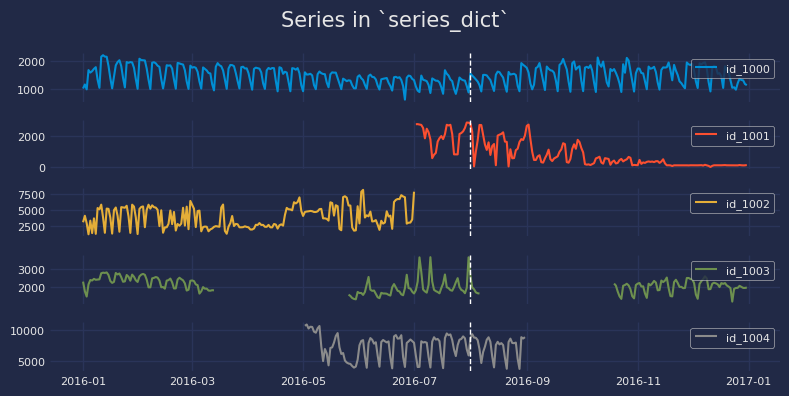

In [6]:
# Plot series
# ==============================================================================
set_dark_theme()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)

for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    axs[i].axvline(pd.to_datetime(end_train) , color='white', linestyle='--', linewidth=1) # End train

fig.suptitle('Series in `series_dict`', fontsize=15)
plt.tight_layout()

In [7]:
# Description of each partition
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(
            f"\tTrain: len={len(series_dict_train[k])}, {series_dict_train[k].index[0]}"
            f" --- {series_dict_train[k].index[-1]}"
        )
    except:
        print(f"\tTrain: len=0")
    try:
        print(
            f"\tTest : len={len(series_dict_test[k])}, {series_dict_test[k].index[0]}"
            f" --- {series_dict_test[k].index[-1]}"
        )
    except:
        print(f"\tTest : len=0")

id_1000:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1001:
	Train: len=30, 2016-07-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1002:
	Train: len=183, 2016-01-01 00:00:00 --- 2016-07-01 00:00:00
	Test : len=0
id_1003:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1004:
	Train: len=91, 2016-05-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=31, 2016-08-01 00:00:00 --- 2016-08-31 00:00:00


## Encoding None

When `encoding` is set to None, no encoding is performed (no column is created). Therefore, all series are treated as a "global unique series".

If a `transformer_series` is provided, a single transformer will be created for all series. It is trained with the concatenation of all values and used to transform each series.

https://skforecast.org/latest/user_guides/independent-multi-time-series-forecasting#series-encoding-in-multi-series

In [13]:
# Training matrix when encoding is None
# ==============================================================================
regressor = LGBMRegressor(random_state=123, verbose=-1, max_depth=5)
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = regressor, 
                 lags               = 3, 
                 encoding           = None, 
                 transformer_series = StandardScaler(),
                 dropna_from_series = False
             )
forecaster.create_train_X_y(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)[0]

,lag_1,lag_2,lag_3,sin_day_of_week,cos_day_of_week,air_temperature,wind_speed
2016-01-04,-0.937556,-0.861254,-0.924730,0.000000,1.000000,6.704778,4.865404
2016-01-05,-0.636371,-0.937556,-0.861254,0.781831,0.623490,2.392998,5.228913
2016-01-06,-0.675282,-0.636371,-0.937556,0.974928,-0.222521,3.015239,2.589456
2016-01-07,-0.652892,-0.675282,-0.636371,0.433884,-0.900969,5.375535,3.693740
2016-01-08,-0.616915,-0.652892,-0.675282,-0.433884,-0.900969,6.842998,2.691845
...,...,...,...,...,...,...,...
2016-07-27,2.336243,1.951473,1.184108,0.974928,-0.222521,29.412603,3.851565
2016-07-28,2.383632,2.336243,1.951473,0.433884,-0.900969,28.429901,3.274959
2016-07-29,2.567539,2.383632,2.336243,-0.433884,-0.900969,26.399671,4.331137
2016-07-30,2.431891,2.567539,2.383632,-0.974928,-0.222521,27.713097,3.783443


In [16]:
# Same single transformer for all series
# ==============================================================================
forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
forecaster.transformer_series_

{'_unknown_level': StandardScaler()}

Also, the residuals are not related to any series, so interval predictions are estimated using the pooled residuals from all series.

In [18]:
# Same residuals for all series
# ==============================================================================
forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
forecaster.in_sample_residuals.keys()

dict_keys(['_unknown_level'])

## Forecasting Unknown levels

`ForecasterAutoregMultiSeries` allows the prediction of unknown series (levels). If a series not seen during training is found during the prediction phase, the forecaster will encode the series according to the following rules:

+ If `encoding` is `'onehot'`, all dummy columns are set to 0.

+ If `encoding` is `'ordinal_category'` or `'ordinal'`, the value of the column `_level_skforecast` is set to `NaN`.

Since the series was not present during training, the last window of the series must be provided when calling the `predict` method.

Since the unknown series are encoded as NaN when the forecaster uses the <code>'ordinal_category'</code> or <code>'ordinal'</code> encoding, only regressors that can handle missing values can be used, otherwise an error will be raised.

https://skforecast.org/latest/user_guides/independent-multi-time-series-forecasting.html#forecasting-unknown-series

In [23]:
# Fit forecaster
# ==============================================================================
regressor = LGBMRegressor(random_state=123, verbose=-1, max_depth=5)
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = regressor, 
                 lags               = 3, 
                 encoding           = 'ordinal', 
                 dropna_from_series = False
             )

forecaster.fit(series=series_dict_train, suppress_warnings=True)
forecaster

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(max_depth=5, random_state=123, verbose=-1) 
Lags: [1 2 3] 
Transformer for series: None 
Transformer for exog: None 
Series encoding: ordinal 
Window size: 3 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: 'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-07-02', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-01'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: boosting_type: gbdt, class_weight: None, colsample_bytree: 1.0, importance_type: split, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-07-31 11:26:41 
Last fit date: 2024-07-31 11:26:41 
Skforecast version: 0.13.0 
Python version: 3.11.5 
Forecaster id: None 

In [28]:
# Forecasting a new series not seen in the training
# ==============================================================================
last_window_item_4 = pd.DataFrame(
    [23.46, 22.3587, 29.348],
    columns = ['item_4'],
    index   = pd.date_range(start="2014-07-13", periods=3, freq="D"),
)
forecaster.predict(
    levels            = 'item_4', 
    steps             = 3, 
    last_window       = last_window_item_4,
    suppress_warnings = False
)

c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:778: UnknownLevelWarning: `levels` {'item_4'} were not included in training. Unknown levels are encoded as NaN, which may cause the prediction to fail if the regressor does not accept NaN values. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=UnknownLevelWarning)
  warnings.warn(


,item_4
2014-07-16,1512.106848
2014-07-17,1491.663892
2014-07-18,1468.100511


In [29]:
# Prediction matrix
# ==============================================================================
forecaster.create_predict_X(
    levels            = 'item_4', 
    steps             = 3, 
    last_window       = last_window_item_4,
    suppress_warnings = False
)['item_4']

c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:778: UnknownLevelWarning: `levels` {'item_4'} were not included in training. Unknown levels are encoded as NaN, which may cause the prediction to fail if the regressor does not accept NaN values. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=UnknownLevelWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:778: UnknownLevelWarning: `levels` {'item_4'} were not included in training. Unknown levels are encoded as NaN, which may cause the prediction to fail if the regressor does not accept NaN values. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=UnknownLevelWarning)
  warnings.warn(


,lag_1,lag_2,lag_3,_level_skforecast
2014-07-16,29.348000,22.358700,23.4600,NaN
2014-07-17,1512.106848,29.348000,22.3587,NaN
2014-07-18,1491.663892,1512.106848,29.3480,NaN
